## This script is used to generate plots related.

In [1]:
# import packages
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
# define the repository path
from common_settings import  obspath, outpath, events_name, \
    obs_events, day_load_flow, hour_load_flow, conct_name, modpath, mod_load_flow

from utils.plotting import cq_line_plot
from utils.concentration import cumulative_lq, excel_save
from utils.signatures import update_cumul_df, load_flow_loc

### plot the time series of discharge, concentration and C-Q

In [2]:
# plot the time series of discharge, concentration and C-Q
const_name = 'cq-NO3'
cq = pd.read_csv(outpath + const_name + '.csv')
cq.Time = pd.to_datetime(cq.Time)
for i in range(cq.shape[0]):
    cq.loc[i, 'index'] = cq.Time[i].strftime("%Y-%m-%d")
cq.set_index('Time', inplace=True, drop=False)
cols = cq.columns

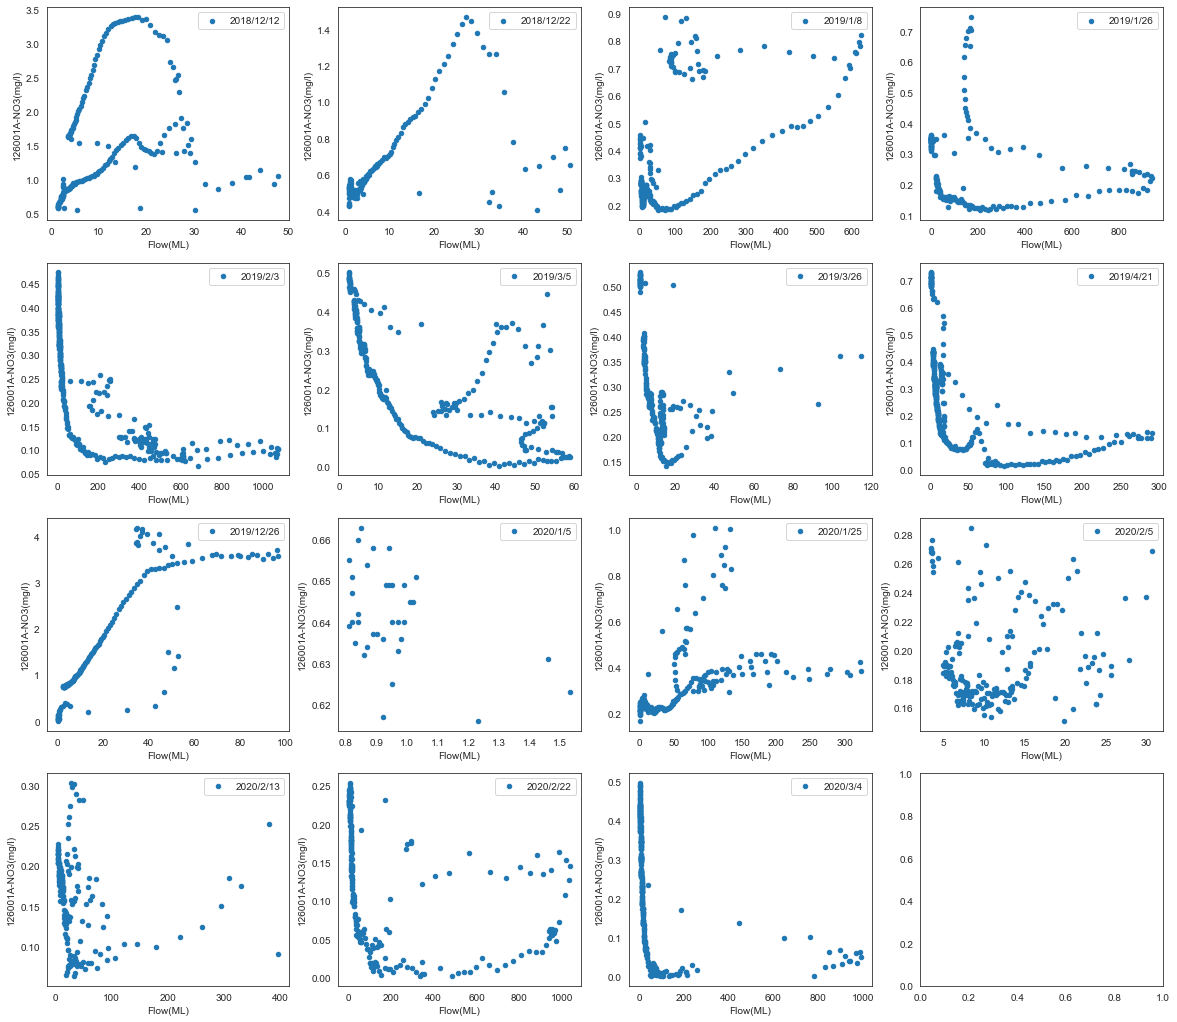

In [45]:
fig, axes = plt.subplots(4, 4, figsize=(20, 18))
k=0
for ii in obs_events.index[59:]:
    row, col = np.floor_divide(k, 4), np.mod(k, 4)
    start, end = obs_events.loc[ii, ['start', 'end']].values
    start = pd.to_datetime(start + ' 00:00:00')
    end = pd.to_datetime(end + ' 23:00:00')
    ylabel_str = 'Flow volume (ML)'
    cq_slice = cq.loc[start:end, :]
    ax_temp = cq_slice.plot(kind='scatter', x=cols[2], y=cols[1], ax=axes[row, col], legend=True)
    ax_temp.legend([obs_events.loc[ii, 'start']])
    k += 1
plt.savefig(f'{outpath}figs/obs_NO3_flow_scatter.png', format='png', dpi=400, layout='tight')

AttributeError: 'Line2D' object has no property 'ylabel'

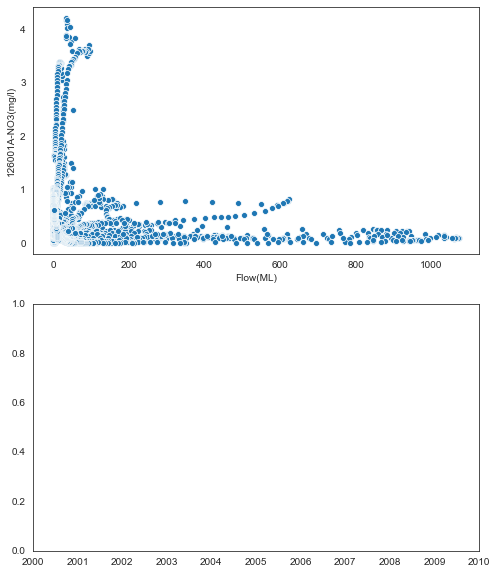

In [170]:
# Plot
sns.set_style('white')
ylabel_str = 'Discharge (ML)'
fig, axes = plt.subplots(2, figsize=(8, 10))
sns.scatterplot(data = cq, x = cols[2], y = cols[1], ax=axes[0])
cq_line_plot(cq, ylabel_str, cols, logy=False, ax=axes[1])
# plt.savefig('../../output/figs/cq-' + const_name + '-test.png', format='png', dpi=300)

In [ ]:
# Plot the data of different small time periods
time_period = ['2019-12-01', '2020-02-01']
cq_sliced = cq.loc[time_period[0]:time_period[1], :]
cq_line_plot(cq_sliced, ylabel_str, cols, logy=True)
# plt.savefig('../../output/figs/cq-' + const_name + 'mobilization-period2.png', format='png', dpi=300)

### The double-mass plot of flow and loads

In [2]:
def double_mass_line(df, xycols, fs, xlabel, ylabel, color=None, legd=None, ls=None, ax=None):
    ax = df.plot(x=xycols[0], y= xycols[1], ax=ax, ls=ls, color=color)
    ax.set_xlabel(xlabel, fontsize=fs)
    ax.set_ylabel(ylabel, fontsize=fs)
    return ax

In [3]:
fn_day = 'obs_year_cumulative_ratio_day'
df_day = pd.read_excel(f'{outpath}{fn_day}.xlsx', sheet_name=[f'obs_year_{i}' for i in range(9)]);

In [4]:
fn_hour = 'obs_year_cumulative_ratio_hour'
df_hour = pd.read_excel(f'{outpath}{fn_hour}.xlsx', None);

In [5]:
fn_mod = 'mod_year_cumulative_ratio_day'
df_mod = pd.read_excel(f'{outpath}{fn_mod}.xlsx', None);

In [9]:
# read inputs (*cumulative_ratio*.xlsx)
xylabel = ['cumul_flow_ratio', 'cumul_load_ratio']
xlabel='Normalized cumulative flow volume'
ylabel='Normalized cumulative mass'
fs=20; fs_legd = 16

F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


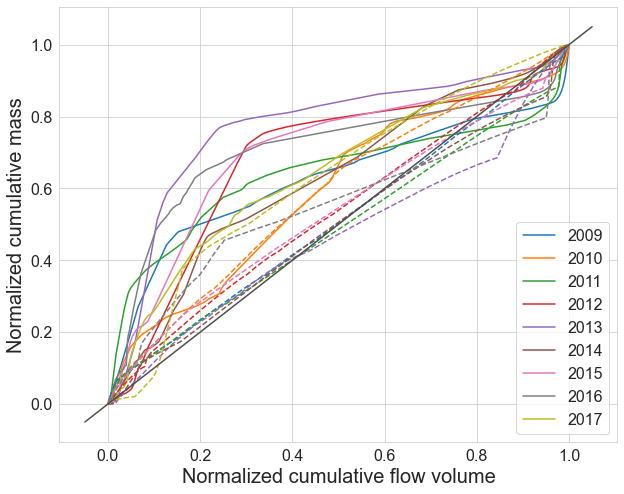

In [11]:
sns.set_style('whitegrid')
sns.color_palette("tab10")
# sns.set_style("ticks", {"xtick.major.size": 14, "ytick.major.size": 14})
plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
legd = []
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
ii = 0
for _, val in df_day.items():
    legd.append(str(val.values[0][0])[0:4])
    double_mass_line(val, xylabel, fs, xlabel, ylabel, colors[ii], legd, ax=ax)
    ii += 1
# for _, val in df_hour.items():
#     legd.append(str(val.values[0][0])[0:4])
#     double_mass_line(val, xylabel, fs, xlabel, ylabel, legd, ax=ax, ls='-.')
ii = 0
for _, val in df_mod.items():    
    legd.append(str(val.values[0][0])[0:4])
    double_mass_line(val, xylabel, fs, xlabel, ylabel, colors[ii], legd, ax=ax, ls='--')
    ii += 1
ax.legend(legd[0:9], fontsize=fs_legd);
ax.plot(ax.get_xlim(), ax.get_xlim(), c=".3")
ax.set_yticklabels(np.round(ax.get_yticks(), 2), size = 16);
ax.set_xticklabels(np.round(ax.get_xticks(), 2), size = 16);
plt.savefig(f'{outpath}figs/{fn_day}.png', format='png', dpi=400)

### Plot Event Mean Concentration (EMC)

In [16]:
# import EMC and tranform into a matrix
emc = pd.read_csv(f'{outpath}obs_storm_event_common.csv', index_col='ID')
# emc = pd.read_csv(f'{outpath}mod_NO3_flow.csv', index_col='ID')

In [17]:
emc_matrix = {year: [] for year in range(2009, 2020)}
# emc_matrix = {year: [] for year in range(2009, 2014)}
emc.start = pd.to_datetime(emc.start)

In [18]:
for ii in emc.index:
    if emc.start[ii].month < 7:
        emc_matrix[emc.start[ii].year - 1].append(emc.loc[ii, 'event_load_coefficients'])
    else:
        emc_matrix[emc.start[ii].year].append(emc.loc[ii, 'event_load_coefficients'])
# convert dict into a dataframe
df_fillna = pd.DataFrame(index=np.arange(1, 13), columns=emc_matrix.keys())
for key, val in emc_matrix.items():
    df_fillna.loc[0:len(val), key] = val
df_fillna.fillna(0, inplace=True)

# creat a mask
mask = np.zeros_like(df_fillna.values)
mask[df_fillna == 0] = True


In [19]:
# creat a mask
mask = np.zeros_like(df_fillna.values)
mask[df_fillna == 0] = True

NameError: name 'mod_df_fillna' is not defined

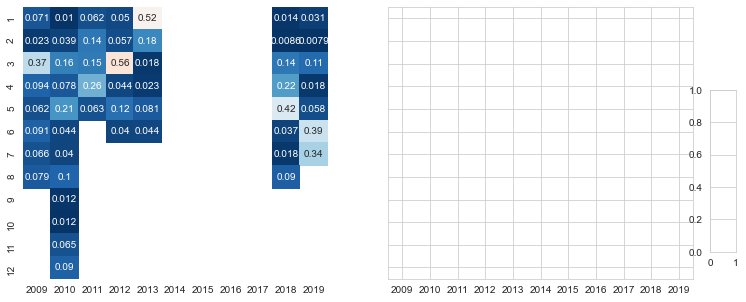

In [20]:
# sns.set_context({"figure.figsize":(17,5)})
sns.axes_style("white")
fig,axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 5))
cbar_ax = fig.add_axes([.92, .2, .03, .45])
ax = sns.heatmap(data=np.array(df_fillna.values), annot=True, mask=mask, vmin=0, vmax=1,
            xticklabels=df_fillna.columns, yticklabels= df_fillna.index,cmap="RdBu_r", ax=axes[0], cbar=0)
ax1 = sns.heatmap(data=np.array(mod_df_fillna.values), annot=True, mask=mod_mask, vmin=0, vmax=1,
            xticklabels=mod_df_fillna.columns, yticklabels= mod_df_fillna.index,cmap="RdBu_r", ax=axes[1], cbar_ax=cbar_ax)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Events', fontsize=16)
ax1.set_xlabel('Year', fontsize=16)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14);
# plt.savefig(f'{outpath}figs/obs_mod_load_coefficients_common.png', format='png', dpi=400)

## The seasonal correlation between concentration and discharge

In [7]:
time_ranges = [[f'{year}/7/1', f'{year}/10/1', f'{year+1}/1/1', f'{year+1}/4/1', f'{year+1}/7/1'] for year in range(2009, 2018)]
df_ratio = pd.DataFrame(index=[str(year) for year in range(2009, 2018)], columns = [1, 2, 3, 4])
cols = day_load_flow.columns
day_load_flow[cols[0]] = day_load_flow[cols[0]] * 1000

In [9]:
day_load_flow

,Linear_Average_Load(t),Flow (Cumecs),Flow(ML),Concentration (mg/L)
Date,,,,
2009-07-01,0.341800,0.1985,17.15,0.019930
2009-07-02,0.453000,0.2026,17.50,0.025886
2009-07-03,0.563800,0.2052,17.73,0.031799
2009-07-04,0.566500,0.1813,15.67,0.036152
2009-07-05,0.682600,0.1994,17.23,0.039617
...,...,...,...,...
2018-06-26,6.076793,0.4312,37.26,0.163092
2018-06-27,5.274421,0.4266,36.86,0.143093
2018-06-28,4.491946,0.4215,36.42,0.123337


F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


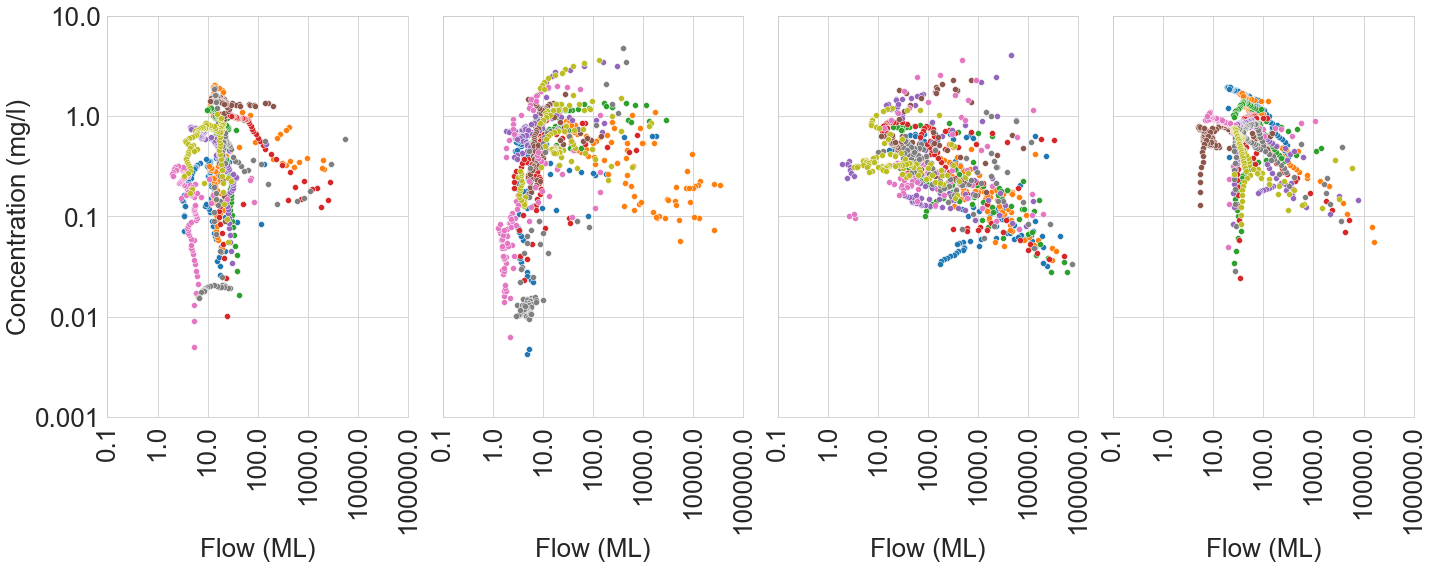

In [12]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharex=True, sharey=True)
for tt in time_ranges:
    for ii in range(len(tt) -1):
        start = pd.to_datetime(tt[ii])
        end = pd.to_datetime(tt[ii + 1]) - datetime.timedelta(days=1)   
        df = load_flow_loc([start, end], day_load_flow, timestep ='d')
        df_sum = df.sum(axis=0)
        sns.scatterplot(data=df, x=cols[2], y=cols[-1], ax=axes[ii])
for ax in axes:
    ax.set(xscale="log", yscale="log")
    ax.set_xticklabels(ax.get_xticks(), fontsize=26, rotation=90)
    ax.set_yticklabels(ax.get_yticks(), fontsize=26)
    ax.set_xlabel('Flow (ML)', fontsize=26)
    ax.set_xlim(0.1, 1e5)
    ax.set_ylim(0.001, 1e1)
axes[0].set_ylabel('Concentration (mg/l)', fontsize=26); #Load (kg) Concentration (mg/l)
# plt.legend(df_ratio.index, fontsize=24);
plt.tight_layout()
plt.savefig(f'{outpath}figs/obs_season_concentration_flow.png', format='png', dpi=300)

## Plot month summarized metrics

In [29]:
df_month = pd.read_csv(f'{outpath}mod_obs_annual.csv', index_col = 'Year')

F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  import sys


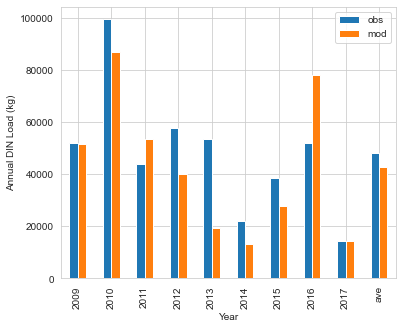

In [31]:
sns.set_style('whitegrid')
ax = df_month.plot(kind='bar', figsize=(6, 5), xlabel='Year', ylabel='Annual DIN Load (kg)', fontsize=10)
ax.set_xlabel(ax.get_xlabel(), fontsize=10);
ax.set_ylabel(ax.get_ylabel(), fontsize=10);
# plt.xticks([i for i in range(0,df_month.shape[0], 6)], df_month.index[::6], rotation=45)
plt.legend(df_month.columns, fontsize=10);
plt.savefig(f'{outpath}figs/mod_obs_annual.png', format='png', dpi=300, layout='tight')

## Plot long term C-Q relationship

In [2]:
time_ranges = ['2009/7/1', '2014/6/30'] 
cols = day_load_flow.columns
day_load_flow[cols[0]] = day_load_flow[cols[0]] * 1000

F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


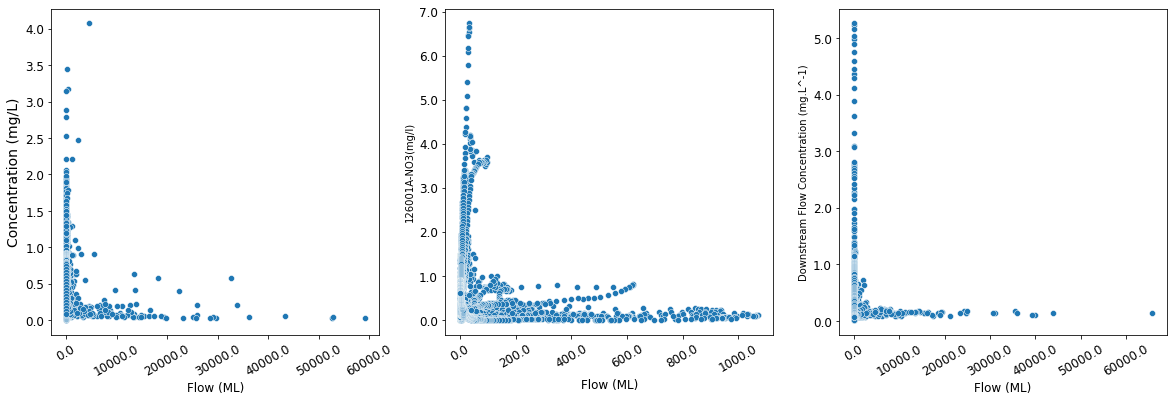

In [9]:
_, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=False, sharey=False)
start, end = pd.to_datetime(time_ranges)
# plot low-freq-obs in axes[0]
df_obs = load_flow_loc([start, end], day_load_flow, timestep ='d')
cols = day_load_flow.columns
sns.scatterplot(data=df_obs, x=cols[2], y=cols[3], ax=axes[0])

# plot high-freq-obs in axes[1]
df_obs_hour = load_flow_loc(['2018/7/1', '2020/6/30'], hour_load_flow, timestep ='h')
cols = hour_load_flow.columns
sns.scatterplot(data=df_obs_hour, x=cols[0], y=cols[1], ax=axes[1])

# plot mod in axes[1]
df_mod = load_flow_loc([start, end], mod_load_flow, timestep ='d')
cols = mod_load_flow.columns
sns.scatterplot(data=df_mod, x=cols[2], y=cols[1], ax=axes[2])
for ax in axes:
#     ax.set(xscale="log", yscale="log")
    ax.set_xticklabels(ax.get_xticks(), fontsize=12, rotation=30)
    ax.set_yticklabels(ax.get_yticks(), fontsize=12)
    ax.set_xlabel('Flow (ML)', fontsize=12)
axes[0].set_ylabel('Concentration (mg/L)', fontsize=14); #Load (kg) Concentration (mg/l)
# plt.savefig(f'{outpath}figs/obs_mod_longterm_load_flow.png', format='png', dpi=400, layout='tight')

## Calcluate the cumulative frequency distributions (CFD) of dissolved concentrations 

### Mod results

F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


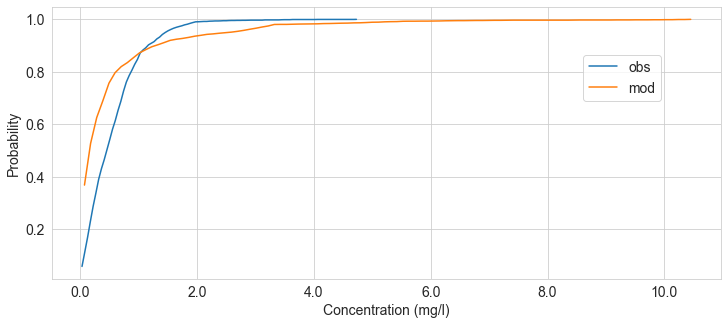

In [13]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(12, 5), sharex=True, sharey=True) 
# Obs results
cols = day_load_flow.columns
time_ranges = [[f'{year}/7/1', f'{year+1}/6/30'] for year in range(2009, 2018)]
for tt in time_ranges:
    df = load_flow_loc(tt, day_load_flow, timestep='d')
df_temp = load_flow_loc([time_ranges[0][0], time_ranges[-1][1]], day_load_flow, timestep='d')
sns.histplot(data = df_temp, x=cols[-1],bins=100,cumulative=True, stat='probability', fill=False, element='poly', alpha=0.7, ax=ax);
# mod results
cols = mod_load_flow.columns
for tt in time_ranges:
    df = load_flow_loc(tt, mod_load_flow, timestep='d')
df_temp = load_flow_loc([time_ranges[0][0], time_ranges[-1][1]], mod_load_flow, timestep='d')
sns.histplot(data = df_temp, x=cols[1],bins=100,cumulative=True, stat='probability', fill=False, element='poly', alpha=0.7, ax=ax);

lgd = [*[year for year in range(2009, 2018)], 'all']
ax.set_xlabel('Concentration (mg/l)', fontsize=14);
ax.set_ylabel('Probability', fontsize=14);
ax.set_xticklabels(ax.get_xticks(), fontsize=14);
# axes[0].set_xlim(0, 10);
ax.set_yticklabels(np.round(ax.get_yticks(), 2), fontsize=14);

lgd = ['obs', 'mod']
plt.legend(lgd, bbox_to_anchor=(0.92, 0.85), fontsize=14)

# plt.savefig(f'{outpath}figs/obs_mod_concentration_cum_freq.png', format='png', dpi=400)

F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


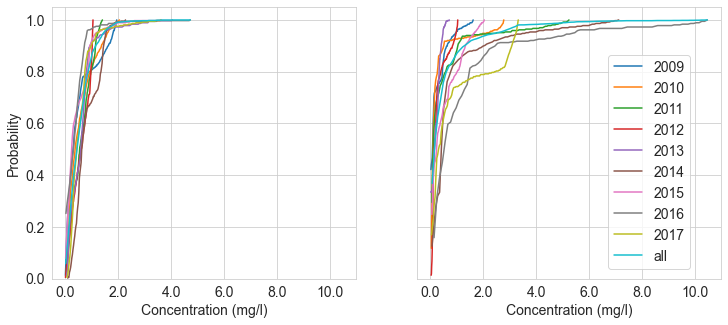

In [14]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True) 
# Obs results
cols = day_load_flow.columns
time_ranges = [[f'{year}/7/1', f'{year+1}/6/30'] for year in range(2009, 2018)]
for tt in time_ranges:
    df = load_flow_loc(tt, day_load_flow, timestep='d')
    ax = sns.histplot(data = df, x=cols[-1],bins=100,cumulative=True, stat='probability', fill=False, element='poly', alpha=0.7, ax=axes[0]);
df_temp = load_flow_loc([time_ranges[0][0], time_ranges[-1][1]], day_load_flow, timestep='d')
sns.histplot(data = df_temp, x=cols[-1],bins=100,cumulative=True, stat='probability', fill=False, element='poly', alpha=0.7, ax=axes[0]);
lgd = [*[year for year in range(2009, 2014)], 'all']
axes[0].set_xlabel('Concentration (mg/l)', fontsize=14);
axes[0].set_ylabel('Probability', fontsize=14);
axes[0].set_xticklabels(axes[1].get_xticks(), fontsize=14);
# axes[1].set_xlim(0, 10);
axes[0].set_yticklabels(np.round(axes[1].get_yticks(), 2), fontsize=14);


# mod results
cols = mod_load_flow.columns
time_ranges = [[f'{year}/7/1', f'{year+1}/6/30'] for year in range(2009, 2018)]

for tt in time_ranges:
    df = load_flow_loc(tt, mod_load_flow, timestep='d')
    sns.histplot(data = df, x=cols[1],bins=100,cumulative=True, stat='probability', fill=False, element='poly', alpha=0.7, ax=axes[1]);
df_temp = load_flow_loc([time_ranges[0][0], time_ranges[-1][1]], mod_load_flow, timestep='d')
sns.histplot(data = df_temp, x=cols[1],bins=100,cumulative=True, stat='probability', fill=False, element='poly', alpha=0.7, ax=axes[1]);
lgd = [*[year for year in range(2009, 2018)], 'all']
axes[1].set_xlabel('Concentration (mg/l)', fontsize=14);
axes[1].set_ylabel('Probability', fontsize=14);
axes[1].set_xticklabels(axes[0].get_xticks(), fontsize=14);
# axes[0].set_xlim(0, 10);
axes[1].set_yticklabels(np.round(axes[0].get_yticks(), 2), fontsize=14);


plt.legend(lgd, bbox_to_anchor=(0.92, 0.85), fontsize=14)

plt.savefig(f'{outpath}figs/obs_mod_concentration_cum_freq.png', format='png', dpi=400)

## Plot long term C distribution

In [66]:
time_ranges = ['2009/7/1', '2018/6/30'] 
cols = day_load_flow.columns
# day_load_flow[cols[0]] = day_load_flow[cols[0]] * 1000

In [68]:
day_load_flow.head()

,Linear_Average_Load(t),Flow (Cumecs),Flow(ML),Concentration (mg/L)
Date,,,,
2009-07-01,341.8,0.1985,17.15,0.019930
2009-07-02,453.0,0.2026,17.50,0.025886
2009-07-03,563.8,0.2052,17.73,0.031799
2009-07-04,566.5,0.1813,15.67,0.036152
2009-07-05,682.6,0.1994,17.23,0.039617


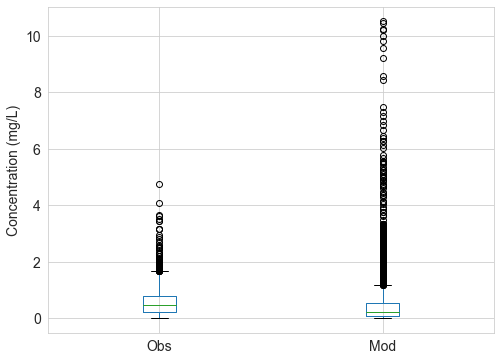

In [70]:
start, end = pd.to_datetime(time_ranges)
# plot obs in axes[0]
df_obs = load_flow_loc([start, end], day_load_flow, timestep ='d')
df_mod = load_flow_loc([start, end], mod_load_flow, timestep ='d')
df_plot = pd.concat([df_obs.filter(regex='Con', axis=1), df_mod.filter(regex='Co', axis=1)], axis=1)
ax = df_plot.boxplot(figsize = (8, 6), fontsize=14)

ax.set_xticklabels(['Obs', 'Mod'], fontsize=14)
ax.set_ylabel('Concentration (mg/L)', fontsize=14)
plt.savefig(f'{outpath}figs/obs_mod_concentration_boxplot.png', format='png', dpi=400)

## Plot Delivery Ratio Surface

In [7]:
df = pd.read_csv(outpath+'DeliveryRatioSurface.csv', index_col='month')
cols = df.columns

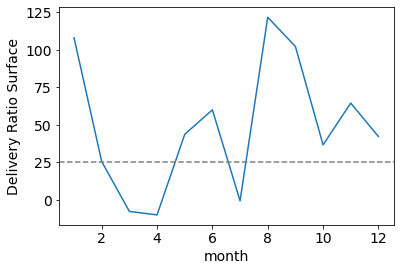

In [13]:
plt.rcParams.update({'font.size': 14})
ax = sns.lineplot(x=df.index, y=cols[-1], data=df);
ax.axhline(y=25, ls='--', color='grey',lw=1.5)
ax.set_ylabel('Delivery Ratio Surface')
plt.savefig(outpath+'figs/DeliveryRatioSurface.png', format='png', dpi=300)